In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm.auto import tqdm
from scipy.special import logit,expit

from src.IterativeFitting import IterativeFitting as IF
from src.HamMethods import ham_vanilla, ham_solved
from src.CorrFuncs import covariance_matrix, trend_est

import jax.numpy as jnp
import jax 
jax.config.update('jax_enable_x64',True)

In [2]:
# Setting seed
np.random.seed(23)

# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 0.05
beta_income = -0.05
beta_sex = 1.0

# Number of samples
n = 40000

# Constructing covariate vectors for additional covariates to adjust
age_vector = np.random.uniform(low=0,high=1,size=n)
income_vector = np.random.uniform(low=0,high=1,size=n)
# sex_vector = np.random.binomial(n=1,p=0.6,size=n)

# Assigning exposure levels and getting relevant x's
exposure_levels = np.array([0.,1.,2.,3.])
xs = np.random.choice(exposure_levels,size = n)
sex_vector = np.random.binomial(n = 1,p = 0.1 + xs/4,size =n )


# Function to generate probabilities of being a case v non-case
other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))

# Actually calculating probabilities on exposures as defined
px = p(xs)

# Actually assigning to case or not
outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

# Constructing and sorting dataframe of outcomes and exposure
df = np.stack([outcomes,xs],axis=1)
# df = df[np.argsort(df[:, 1])]

# Getting xs corresponding to each exposure interval and corresponding case information
categories = [df[np.where(df[:,1] == i)[0]] for i in exposure_levels]
N = np.array([df.shape[0] for df in categories])
cases = np.array([np.sum(df[:,0]) for df in categories])
non_cases = N - cases
a_0, A = cases[0], cases[1:]
b_0, B = non_cases[0], non_cases[1:]
M = np.sum(cases)

# Getting crude estimates to compare
crude = lambda x,y: (x/y) / (a_0/b_0)
crudeors = crude(A,B)

# Constructing dummy variables with respect to exposure level
x = exposure_levels[1:]

to_adjust_df = pd.DataFrame({
    'age':age_vector,
    'income':income_vector,
    'sex':sex_vector,
    'exposure':xs.astype(int)
})
to_adjust_df['intercept']=1

to_adjust_df = pd.concat([to_adjust_df,pd.get_dummies(to_adjust_df['exposure'],prefix='exposure').astype(int).iloc[:,1:]],axis=1).drop('exposure',axis=1)

results = sm.Logit(endog=df[:,0], exog=to_adjust_df).fit()
true_C = results.cov_params().to_numpy()[4:,4:]
true_C_inv = np.linalg.inv(true_C)

# Get log-ORs and corresponding variances
L = results.params.to_numpy()[4:]
v = (results.bse.to_numpy()[4:])**2

Optimization terminated successfully.
         Current function value: 0.646961
         Iterations 5


In [4]:
# Running GL
it_fit_ex = IF(L,A,N,M)
Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

gl_C = covariance_matrix(Ap,Bp,a0p,b0p,v)
inv_gl_C = np.linalg.inv(gl_C)

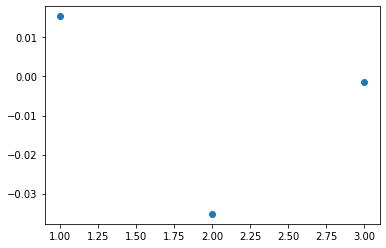

In [5]:
plt.scatter(x,L)

In [68]:
import jax
def marginal_like(gamma2):
    n_groups = 3
    I =jnp.eye(n_groups)
    oneoneT = jnp.ones((n_groups,n_groups))
    D = jnp.diag(v)
    Ca = D - gamma2*I + gamma2*oneoneT
    sign,logabsdet = jnp.linalg.slogdet(Ca)
    invC = jnp.linalg.inv(Ca)
    beta = x.T@invC@L/(x.T@invC@x)
    res = L-x*beta
    res = 0*x
    correction =  (1/2)*jnp.log(x.T@invC@x)

    return jnp.array([0.5 * (res).T@invC@(res) + 0.5 * logabsdet + correction,sign])

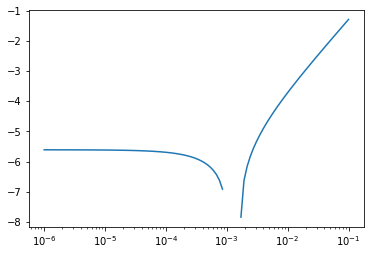

In [70]:
gamma2_vals = jnp.logspace(-6,-1,100)
j_mar = jax.jit(jax.vmap(marginal_like))
vals = j_mar(gamma2_vals)
plt.plot(gamma2_vals[vals[:,1]>0],vals[:,0][vals[:,1]>0])
plt.xscale('log')

In [71]:
gamma2_opt = gamma2_vals[jnp.argmin(vals[:,0][vals[:,1]>0])]

In [72]:
gamma2_opt

Array(0.00095455, dtype=float64)

In [73]:
n_groups = 3
I =jnp.eye(n_groups)
oneoneT = jnp.ones((n_groups,n_groups))
D = jnp.diag(v)
Cml = D - gamma2_opt*I + gamma2_opt*oneoneT

In [74]:
#(D-true_C)/true_C

In [75]:
Cml

Array([[0.00087373, 0.00095455, 0.00095455],
       [0.00095455, 0.00099766, 0.00095455],
       [0.00095455, 0.00095455, 0.00123755]], dtype=float64)

In [76]:
np.around((Cml - true_C)/true_C,4)

Array([[0.    , 1.001 , 0.855 ],
       [1.001 , 0.    , 0.5028],
       [0.855 , 0.5028, 0.    ]], dtype=float64)

In [54]:
np.around((gl_C - true_C)/true_C,4)

array([[ 0.    , -0.016 ,  0.0135],
       [-0.016 ,  0.    , -0.1173],
       [ 0.0135, -0.1173,  0.    ]])

In [63]:
x.T@jnp.linalg.inv(gl_C)@L/(x.T@jnp.linalg.inv(gl_C)@x)

Array(-0.0066732, dtype=float64)

In [64]:
x.T@jnp.linalg.inv(D)@L/(x.T@jnp.linalg.inv(D)@x)

Array(-0.00453136, dtype=float64)

In [62]:
x.T@jnp.linalg.inv(Cml)@L/(x.T@jnp.linalg.inv(Cml)@x)

Array(-0.00748569, dtype=float64)